**Partie II**

In this section, we focus on two other important aspects of deep learning: speeding up learning with GPU cards and the ability to use pretrained networks.

To illustrate the first aspect, we will use the GPUs available under Google Colab. To do this, before starting to read the notebook, go to **Modifier**/**Modifier les param du notebook** and select a GPU.

For the second aspect, we will work on a binary classification problem using a small dataset ("hymenoptera_data"). We will see the benefits of using a network that has already been trained on a larger dataset and a more general classification task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [2]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda:0") # 0 is the index of the GPU
  print("You are on GPU !")
else:
  print('Change the runtime type to GPU')

You are on GPU !


## **A.** Load and viz the Hymenoptera dataset:

In [3]:
# download the dataset
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
! unzip -qq hymenoptera_data.zip

--2023-12-29 18:42:00--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.71, 18.160.200.126, 18.160.200.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   110MB/s    in 0.4s    

2023-12-29 18:42:00 (110 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
dir_data = 'hymenoptera_data'
print(os.listdir(dir_data))

['train', 'val']


The dataset is in a standard format, and we can manipulate it with a ready-to-use dataset object of the datasets.ImageFolder class:

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(dir_data, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print('Dataset sizs:' )
print(dataset_sizes)

Dataset sizs:
{'train': 244, 'val': 153}


Since the provided dataset is very small, we need to maximize its utility. We will produce new images through additional transformations that preserve the nature of the object (data augmentation). \\
In the code, transforms.*RandomResizedCrop()*, *transforms.RandomHorizontalFlip()* and *transforms.RandomVerticalFlip()* apply horizontal or vertical axis symmetry with a probability of 1/2. Note that these transformations might not be suitable for other datasets like MNIST since the mirror image of a digit is generally not another digit. Therefore, transformations often need to be adapted to the nature of the dataset. \\
Some images are presented below.


In [6]:
def imshow(inp, ax=None, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
      plt.imshow(inp)
      plt.title(title)
    else:
      ax.imshow(inp)
      ax.set_title(title)

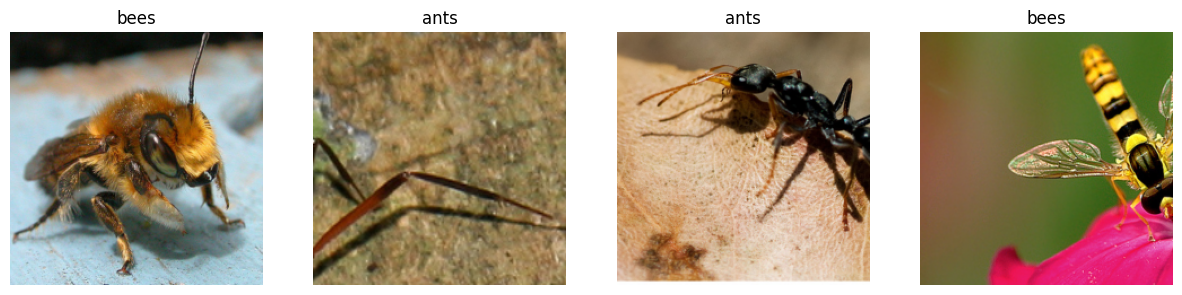

In [7]:
def plot_batch(images, labels, class_names):
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        axs[i].axis('off')
        imshow(images[i],axs[i],class_names[labels[i]])
    plt.show()
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
class_names = image_datasets['train'].classes
# Assuming `inputs` is a batch of images and `classes` are the corresponding class labels
plot_batch(inputs, classes, class_names)


## **B.** Using a Graphics Card:

Let's start by checking if, for typical architectures like ResNet, using a GPU significantly improves computation time. We will begin by loading the lightest of the ResNet architectures and select an appropriate loss function.

**Exercise**

- Load an untrained ResNet18. How many total weights does it contain? Check [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).

- How many neurons does the last layer of the network have?

- Modify the last layer of the classifier so that it has as many neurons as there are classes in hymenoptera_data:

In [8]:
model = models.resnet18(pretrained=False)
# YOUR CODE HERE
# raise NotImplementedError()
nb_weights = 0
for module in model.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear) or isinstance(module, nn.BatchNorm2d):
    for parameters in module.parameters():
      nb_weights += torch.numel(parameters)
print('Le nombre de poids du modèle est : ', nb_weights)

print(model)

Le nombre de poids du modèle est :  11689512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**Note:** Batch normalization operations facilitate learning but won't be detailed here. In summary, they center/reduce each feature map over the batch and then renormalize. The two renormalization parameters (mean and standard deviation) are trainable.

In [9]:
# Neurons in the last layer
# YOUR CODE HERE
# raise NotImplementedError()
nb_neurons= model.fc.out_features
print('Le nombre de neurones de la dernière couche : ', nb_neurons)

Le nombre de neurones de la dernière couche :  1000


In [10]:
# Modification of the last layer of the classifier
def get_model(pretrained):
  model = models.resnet18(pretrained=pretrained)
  # YOUR CODE HERE
  # raise NotImplementedError()
  num_ftrs = model.fc.in_features

  model.fc = nn.Linear(num_ftrs, 2)
  return model

model = get_model(False)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Exercise:** Is there a softmax layer at the end of the ResNet architecture?

Pas de softmax layer

Now, let's define the negative log-likelihood as the cost function. To compute the log-likelihood, we could add a LogSoftmax layer to the ResNet. Yet it's easier and more common to use a loss function that includes *LogSoftmax*. In this regard, in PyTorch,  *nn.CrossEntropyLoss* combines both *LogSoftmax* and *NLLLoss*.

In [11]:
loss_fn =  nn.CrossEntropyLoss()

Finally, let's define a function that incorporates the training loop.




**Exercise:**
- Complete the *train_model* function, which takes a model, a loss function, an optimizer, and a number of epochs as arguments.
- Train the ResNet over one epoch with mini-batches of 64 images.

In [12]:
def train_model(model, loss_fn, optimizer, num_epochs=1):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                # Weights are not updated during the validation phase

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                # 1. zeroing grads
                # YOUR CODE HERE
                # raise NotImplementedError()
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    # forward step (outputs = ...)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    # YOUR CODE HERE
                    # raise NotImplementedError()
                    if phase == 'train':
                        # backward step
                        loss.backward()
                        optimizer.step()
                        # YOUR CODE HERE
                        # raise NotImplementedError()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model

In [13]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

model = get_model(pretrained=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Launch the training over 1 epoch:
model = train_model(model, loss_fn, optimizer, num_epochs=1)
# YOUR CODE HERE
# raise NotImplementedError()

Epoch 0/0
----------
train Loss: 0.7207 Acc: 47.54%
val Loss: 0.6950 Acc: 53.59%
Training complete in 1m 42s


With more than 10 million parameters, training a ResNet on a CPU is much slower than the networks in Part I. \\
Let's repeat the same training using the GPU.

In [ ]:
print(f'Runtime device :{device}')

# Load the model to the GPU:
model = model.to(device)

Runtime device :cuda:0


To load a torch.tensor on GPU, the syntax is the same:

In [ ]:
x = torch.rand(2,1,4,4)
print("On CPU :\n",x)
x = x.to(device)
# Note: You can also use .cuda() without specifying the device name
# but this method is not recommended especially in a multi-gpu environment
print("On GPU :\n",x)

# bring back the x tensor to the CPU RAM:
x = x.to('cpu') # or x.cpu()
print('Back to CPU:\n',x)

On CPU :
 tensor([[[[0.7425, 0.8919, 0.2427, 0.0423],
          [0.7777, 0.9767, 0.0039, 0.9760],
          [0.6917, 0.5700, 0.3175, 0.3680],
          [0.5599, 0.4281, 0.2678, 0.0051]]],


        [[[0.6258, 0.6698, 0.0831, 0.0385],
          [0.3958, 0.0464, 0.2745, 0.4282],
          [0.6771, 0.3490, 0.8119, 0.4975],
          [0.1476, 0.6047, 0.8027, 0.9691]]]])
On GPU :
 tensor([[[[0.7425, 0.8919, 0.2427, 0.0423],
          [0.7777, 0.9767, 0.0039, 0.9760],
          [0.6917, 0.5700, 0.3175, 0.3680],
          [0.5599, 0.4281, 0.2678, 0.0051]]],


        [[[0.6258, 0.6698, 0.0831, 0.0385],
          [0.3958, 0.0464, 0.2745, 0.4282],
          [0.6771, 0.3490, 0.8119, 0.4975],
          [0.1476, 0.6047, 0.8027, 0.9691]]]], device='cuda:0')
Back to CPU:
 tensor([[[[0.7425, 0.8919, 0.2427, 0.0423],
          [0.7777, 0.9767, 0.0039, 0.9760],
          [0.6917, 0.5700, 0.3175, 0.3680],
          [0.5599, 0.4281, 0.2678, 0.0051]]],


        [[[0.6258, 0.6698, 0.0831, 0.0385],
       

**Exercice :**
- Complete the fonction *train_model_gpu* to train the model on GPU.
- Compare the CPU and GPU training times.

In [ ]:
def train_model_gpu(model, loss_fn, optimizer, num_epochs=1):
    # Record the starting time
    since = time.time()
    # Loop through epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Iterate through training and validation phases
        for phase in ['train', 'val']:
            # Set the model to training mode during the training phase, and evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize counters for loss and correct predictions
            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches in the data loader
            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the specified device (GPU)
                # YOUR CODE HERE
                # raise NotImplementedError()
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Zero the gradients in the optimizer (same as in train_model())
                # YOUR CODE HERE
                # raise NotImplementedError()
                optimizer.zero_grad()
                # Forward pass: compute model outputs and predictions (same as in train_model())
                with torch.set_grad_enabled(phase == 'train'):
                    # YOUR CODE HERE
                    # raise NotImplementedError()
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    # Backward pass and optimization step if in the training phase (same as in train_model())
                    # YOUR CODE HERE
                    #raise NotImplementedError()
                    if (phase == 'train'):
                      loss.backward()
                      optimizer.step()
                # Update counters
                running_loss += loss.item() * inputs.size(0)
                acc = torch.sum(preds == labels.data)
                # The 'acc' tensor is distributed across different parts of the GPU
                # Gather the 'acc' tensor on the CPU before accumulation
                acc = acc.to('cpu')
                running_corrects += acc
                # YOUR CODE HERE
                # raise NotImplementedError()

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Print epoch statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')

    # Calculate and print the total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    # Return the trained model
    return model


model = get_model(pretrained=False).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

model = train_model_gpu(model, loss_fn, optimizer, num_epochs=1)

Epoch 0/0
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.7056 Acc: 46.31%
val Loss: 0.7086 Acc: 35.29%
Training complete in 0m 3s


### **GPU**
A GPU, or Graphics Processing Unit, is a specialized electronic circuit designed to accelerate the processing of images and videos. Originally developed for rendering graphics in video games, GPUs have evolved into highly parallel processors that excel at performing many simultaneous calculations. Unlike CPUs (Central Processing Unit), the GPUs are optimized for parallel processing tasks.

Key characteristics of GPUs include:

1. **Parallel Processing:** GPUs consist of a large number of cores, allowing them to handle multiple tasks simultaneously. This makes them well-suited for parallelizable computations.

2. **Vectorized Processing:** GPUs are designed to efficiently perform operations on vectors and matrices. This is particularly beneficial for tasks such as linear algebra operations, which are common in machine learning and scientific computing.

3. **High Memory Bandwidth:** GPUs have high-speed memory to quickly access and manipulate large amounts of data, making them suitable for tasks that involve substantial data throughput.

4. **Floating-Point Performance:** GPUs are optimized for floating-point arithmetic, which is important for applications that require precision in numerical calculations.

5. **Specialized Compute APIs:** Modern GPUs support specialized compute APIs (Application Programming Interfaces) such as CUDA (Compute Unified Device Architecture) for NVIDIA GPUs or OpenCL (Open Computing Language), which allows developers to offload parallelizable tasks to the GPU.

6. **General-Purpose GPU Computing:** Beyond graphics rendering, GPUs are now widely used for general-purpose computing, including scientific simulations, machine learning, data analysis, and other computationally intensive tasks.

In the context of machine learning, deep learning frameworks like TensorFlow and PyTorch leverage GPUs to accelerate the training of neural networks. The parallel processing capabilities of GPUs enable the simultaneous computation of numerous mathematical operations, significantly speeding up training times compared to using only a CPU.

## **C.**  Improving the Training Procedure:

Before comparing different transfer approaches, let's improve the training procedure a bit. We can add momentum to the gradient descent. The  [increment calculation](https://pytorch.org/docs/master/optim.html#torch.optim.SGD) will depend not only on the current gradient but also on past increment values stored in $d_i$:

\begin{equation}
d_i^{t+1} = momentum \times d_i^{t} +    \dfrac{\partial \mathcal{L_{batch}^{t+1}}} {\partial{\omega_i}} \\
w_i^{t+1}  = w_i^{t} - lr \times d_i^{t+1}
\end{equation}

Here is an example:

`optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)`


Next, we'll add a *scheduler* that gradually decreases the learning rate *lr*. With the following *scheduler*, every five epochs, *lr* is multiplied by gamma = 0.1. \\
`scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)`

The *scheduler* needs access to the *lr* in the optimizer, so it is passed as an argument. The scheduler acts on *lr* only at the end of an epoch, and to make this action effective, you need to add this line outside the loader iteration loop:

`scheduler.step()`


**Exercise**: Integrate these elements into the training function. Check that the learning rate decreases as expected.


In [14]:
def train_model_gpu_scheduler(model, loss_fn, optimizer,scheduler, num_epochs=1):
    # Record the starting time
    since = time.time()
    # Loop through epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Iterate through training and validation phases
        for phase in ['train', 'val']:
            # Set the model to training mode during the training phase, and evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize counters for loss and correct predictions
            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches in the data loader
            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the specified device (same as in train_model_gpu())
                # YOUR CODE HERE
                # raise NotImplementedError()
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Zero the gradients in the optimizer (same as in train_model())
                # YOUR CODE HERE
                # raise NotImplementedError()
                optimizer.zero_grad()
                # Forward pass: compute model outputs and predictions (same as in train_model())
                with torch.set_grad_enabled(phase == 'train'):
                    # YOUR CODE HERE
                    # raise NotImplementedError()
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    if (phase == 'train'):
                      loss.backward()
                      optimizer.step()
                    # Backward pass and optimization step if in the training phase (same as in train_model())
                    # YOUR CODE HERE
                    #raise NotImplementedError()

                # Update counters
                running_loss += loss.item() * inputs.size(0)
                acc = torch.sum(preds == labels.data)
                # The 'acc' tensor is distributed across different parts of the GPU
                # Gather the 'acc' tensor on the CPU before accumulation (same as in train_model_gpu())
                acc = acc.to('cpu')
                running_corrects += acc
                # YOUR CODE HERE
                # raise NotImplementedError()

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Print epoch statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')
        # update the learning rate
        # print it (hint: look at optimizer.param_groups)
        # YOUR CODE HERE
        # raise NotImplementedError()
        scheduler.step()
        print('Learning rate : ',optimizer.param_groups[0]['lr'])
    # Calculate and print the total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model


In [15]:
model = get_model(pretrained=False).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

model = train_model_gpu_scheduler(model, loss_fn, optimizer, scheduler, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 0.6986 Acc: 50.82%
val Loss: 0.6871 Acc: 59.48%
Learning rate :  0.001
Epoch 1/9
----------
train Loss: 0.6860 Acc: 52.46%
val Loss: 0.7094 Acc: 45.75%
Learning rate :  0.0001
Epoch 2/9
----------
train Loss: 0.6745 Acc: 55.33%
val Loss: 0.7215 Acc: 45.75%
Learning rate :  0.0001
Epoch 3/9
----------
train Loss: 0.6631 Acc: 55.74%
val Loss: 0.7186 Acc: 45.10%
Learning rate :  1e-05
Epoch 4/9
----------
train Loss: 0.6535 Acc: 58.20%
val Loss: 0.7164 Acc: 45.75%
Learning rate :  1e-05
Epoch 5/9
----------
train Loss: 0.6560 Acc: 58.20%
val Loss: 0.7098 Acc: 47.71%
Learning rate :  1.0000000000000002e-06
Epoch 6/9
----------
train Loss: 0.6564 Acc: 60.66%
val Loss: 0.7045 Acc: 49.02%
Learning rate :  1.0000000000000002e-06
Epoch 7/9
----------
train Loss: 0.6504 Acc: 60.66%
val Loss: 0.6971 Acc: 49.67%
Learning rate :  1.0000000000000002e-07
Epoch 8/9
----------
train Loss: 0.6533 Acc: 61.48%
val Loss: 0.6905 Acc: 50.98%
Learning rate :  1.000000000000000

**Important note:** As you may notice, there are quite a few parameters to set, `learning rate`, `momentum`, `gamma`, `step_size`, etc... Typically, we use the parameterization that achieves the best scores on the validation dataset. To do this, we save the weights during training as soon as a validation record is reached. Note that by selecting the model this way, we are essentially training on the validation dataset. \\
This is why evaluating a selected model on the validation set always takes place on an independent **test dataset**, separate from the validation and training sets.

For reference, here's how to store model weights in PyTorch:
```python
import copy

# At the end of each epoch, save the best model:
if phase == "val" and epoch_acc > best_val_acc:
  best_model_wts = copy.deepcopy(model.state_dict())

# After training, before testing the model, load the best model:
model.load_state_dict(best_model_wts)
```

## **D.** Impact of pretraining on performance:

Training is faster on a GPU, but it only leads to a very poor score, barely better than random chance. To improve performance, a simple idea is to use a network trained on a similar (or more general) task as a starting point for learning. Here, it works particularly well with networks trained on ImageNet, whose convolutional filters are already very rich.

**Note:**
This method is refered to as **fine-tuning** a **pretrained model**.

**Exercise**:
Modify the training function to retrieve successive training and validation accuracies.

In [17]:
def train(model, loss_fn, optimizer,scheduler, num_epochs=1):
    # Record the starting time
    since = time.time()
    # YOUR CODE HERE
    # raise NotImplementedError()
    # Record the starting time
    # Loop through epochs
    accs = {'train':[], 'val':[]}
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Iterate through training and validation phases
        for phase in ['train', 'val']:
            # Set the model to training mode during the training phase, and evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize counters for loss and correct predictions
            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches in the data loader
            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the specified device (same as in train_model_gpu())
                # YOUR CODE HERE
                # raise NotImplementedError()
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Zero the gradients in the optimizer (same as in train_model())
                # YOUR CODE HERE
                # raise NotImplementedError()
                optimizer.zero_grad()
                # Forward pass: compute model outputs and predictions (same as in train_model())
                with torch.set_grad_enabled(phase == 'train'):
                    # YOUR CODE HERE
                    # raise NotImplementedError()
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    if (phase == 'train'):
                      loss.backward()
                      optimizer.step()
                    # Backward pass and optimization step if in the training phase (same as in train_model())
                    # YOUR CODE HERE
                    #raise NotImplementedError()

                # Update counters
                running_loss += loss.item() * inputs.size(0)
                acc = torch.sum(preds == labels.data)
                # The 'acc' tensor is distributed across different parts of the GPU
                # Gather the 'acc' tensor on the CPU before accumulation (same as in train_model_gpu())
                acc = acc.to('cpu')
                running_corrects += acc
                # YOUR CODE HERE
                # raise NotImplementedError()

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            accs[phase].append(epoch_acc)

            # Print epoch statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')
        # update the learning rate
        # print it (hint: look at optimizer.param_groups)
        # YOUR CODE HERE
        # raise NotImplementedError()
        scheduler.step()
        print('Learning rate : ',optimizer.param_groups[0]['lr'])
    # Calculate and print the total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model, accs


**Exercise:** Compare two ResNet18 trainings, one randomly initialized and the other pre-trained, using learning curves, over 25 epochs.

In [18]:
max_epochs = 25
# Learning "from scratch" (random weights) :
# get the model
model = get_model(False)
# Put the model on GPU
model = model.to(device)
# get the loss, optimize, the scheduler and starting the training
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()
# ...
resnet_scratch, accs_scratch = train(model, loss_fn, optimizer,scheduler, num_epochs=max_epochs)
# YOUR CODE HERE
# raise NotImplementedError()


Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.7222 Acc: 52.46%
val Loss: 0.6903 Acc: 47.06%
Learning rate :  0.001
Epoch 1/24
----------
train Loss: 0.6993 Acc: 49.59%
val Loss: 0.7037 Acc: 45.75%
Learning rate :  0.0001
Epoch 2/24
----------
train Loss: 0.6792 Acc: 56.15%
val Loss: 0.7126 Acc: 45.75%
Learning rate :  0.0001
Epoch 3/24
----------
train Loss: 0.6733 Acc: 57.79%
val Loss: 0.7070 Acc: 48.37%
Learning rate :  1e-05
Epoch 4/24
----------
train Loss: 0.6569 Acc: 59.02%
val Loss: 0.7029 Acc: 49.02%
Learning rate :  1e-05
Epoch 5/24
----------
train Loss: 0.6634 Acc: 59.84%
val Loss: 0.6940 Acc: 49.67%
Learning rate :  1.0000000000000002e-06
Epoch 6/24
----------
train Loss: 0.6638 Acc: 56.56%
val Loss: 0.6869 Acc: 51.63%
Learning rate :  1.0000000000000002e-06
Epoch 7/24
----------
train Loss: 0.6579 Acc: 60.66%
val Loss: 0.6822 Acc: 54.90%
Learning rate :  1.0000000000000002e-07
Epoch 8/24
----------
train Loss: 0.6628 Acc: 59.84%
val Loss: 0.6768 Acc: 56.86%
Learning rate :  1.0000000000000002e-07
Epoch 9

In [19]:
# fine tuning a pretrained model:
model = get_model(True)
# Put the model on GPU
model = model.to(device)
# get the loss, optimize, the scheduler and starting the training
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()
# ...
resnet_ft, accs_ft = train(model, loss_fn, optimizer,scheduler, num_epochs=max_epochs)
# YOUR CODE HERE
# raise NotImplementedError()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


Epoch 0/24
----------
train Loss: 0.6653 Acc: 57.79%
val Loss: 0.5363 Acc: 81.70%
Learning rate :  0.001
Epoch 1/24
----------
train Loss: 0.5746 Acc: 72.13%
val Loss: 0.4264 Acc: 89.54%
Learning rate :  0.0001
Epoch 2/24
----------
train Loss: 0.5047 Acc: 77.46%
val Loss: 0.4238 Acc: 88.89%
Learning rate :  0.0001
Epoch 3/24
----------
train Loss: 0.4748 Acc: 80.33%
val Loss: 0.4186 Acc: 86.93%
Learning rate :  1e-05
Epoch 4/24
----------
train Loss: 0.4690 Acc: 80.33%
val Loss: 0.4215 Acc: 86.27%
Learning rate :  1e-05
Epoch 5/24
----------
train Loss: 0.4678 Acc: 83.20%
val Loss: 0.4227 Acc: 87.58%
Learning rate :  1.0000000000000002e-06
Epoch 6/24
----------
train Loss: 0.4981 Acc: 79.92%
val Loss: 0.4238 Acc: 87.58%
Learning rate :  1.0000000000000002e-06
Epoch 7/24
----------
train Loss: 0.4719 Acc: 81.97%
val Loss: 0.4271 Acc: 87.58%
Learning rate :  1.0000000000000002e-07
Epoch 8/24
----------
train Loss: 0.4635 Acc: 84.02%
val Loss: 0.4286 Acc: 86.93%
Learning rate :  1.000000

**Learning curves**

<ipython-input-20-9cdd87cbd3e4>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


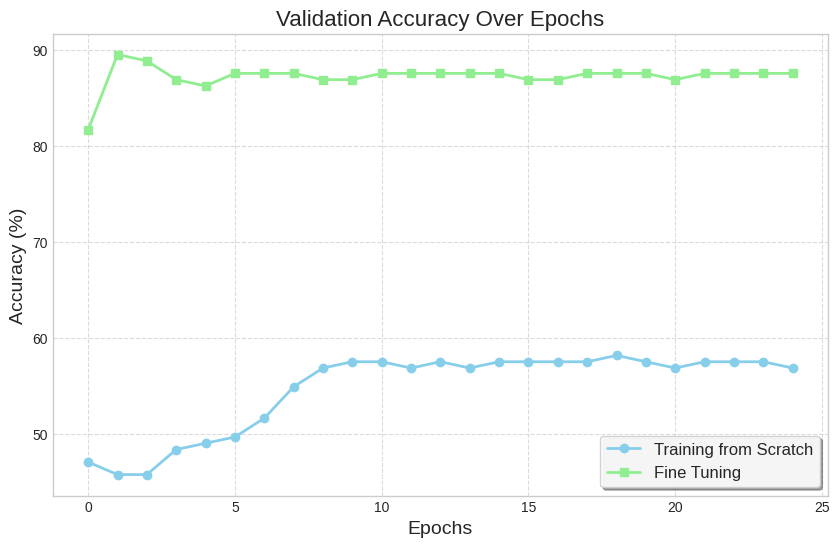

In [20]:
# Set the style
plt.style.use('seaborn-whitegrid')
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the data with improved style
epochs = np.arange(max_epochs)

# YOUR CODE HERE
#raise NotImplementedError()
# Assuming accs_scratch and accs_ft are dictionaries with 'val' as a key
# you can use the following lines
ax.plot(epochs, 100 * np.array(accs_scratch['val']), color='skyblue',
       label='Training from Scratch', marker='o', linestyle='-', linewidth=2)
ax.plot(epochs, 100 * np.array(accs_ft['val']), color='lightgreen',
        label='Fine Tuning', marker='s', linestyle='-', linewidth=2)

# Set title and axis labels
ax.set_title('Validation Accuracy Over Epochs', fontsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)

# Set grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)
# Add legend with a border and shadow
ax.legend(frameon=True, fancybox=True, shadow=True, framealpha=0.9, fontsize=12)
plt.show()


The fine-tuning approach has many variations that fit into the broader framework of **transfer learning**. Partial fine-tuning, as illustrated in the following exercise, is one of these variations.

**Exercise:** Instead of retraining all the weights, you can simply use the weights of the classifier. This is referred to as *freezing* the other weights during retraining.
- Implement this approach and compare it with the previous ones.

In [24]:
resnet = torchvision.models.resnet18(pretrained=True)

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

# freeze all the layers except the classifier (the last dense layers at end)
# YOUR CODE HERE
# raise NotImplementedError()
for module in resnet.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.BatchNorm2d):
    for parameter in module.parameters():
      parameter.requires_grad = False

freezed_resnet = resnet.to(device)
optimizer = torch.optim.SGD(freezed_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# train the model
# ...
freezed_resnet, accs_freezing = train(freezed_resnet, loss_fn, optimizer, exp_lr_scheduler, num_epochs=max_epochs)
# YOUR CODE HERE
# raise NotImplementedError()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.7402 Acc: 50.82%
val Loss: 0.6073 Acc: 65.36%
Learning rate :  0.001
Epoch 1/24
----------
train Loss: 0.7010 Acc: 55.74%
val Loss: 0.5721 Acc: 68.63%
Learning rate :  0.001
Epoch 2/24
----------
train Loss: 0.5881 Acc: 68.85%
val Loss: 0.4426 Acc: 81.70%
Learning rate :  0.001
Epoch 3/24
----------
train Loss: 0.4909 Acc: 76.23%
val Loss: 0.3702 Acc: 88.24%
Learning rate :  0.001
Epoch 4/24
----------
train Loss: 0.4151 Acc: 86.48%
val Loss: 0.3355 Acc: 89.54%
Learning rate :  0.0001
Epoch 5/24
----------
train Loss: 0.3732 Acc: 89.75%
val Loss: 0.3362 Acc: 89.54%
Learning rate :  0.0001
Epoch 6/24
----------
train Loss: 0.3571 Acc: 89.75%
val Loss: 0.3325 Acc: 89.54%
Learning rate :  0.0001
Epoch 7/24
----------
train Loss: 0.3816 Acc: 85.66%
val Loss: 0.3252 Acc: 90.20%
Learning rate :  0.0001
Epoch 8/24
----------
train Loss: 0.3651 Acc: 89.34%
val Loss: 0.3197 Acc: 90.20%
Learning rate :  0.0001
Epoch 9/24
----------
train Loss: 0.3696 Acc: 89.3

<ipython-input-26-01c7d1c41796>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


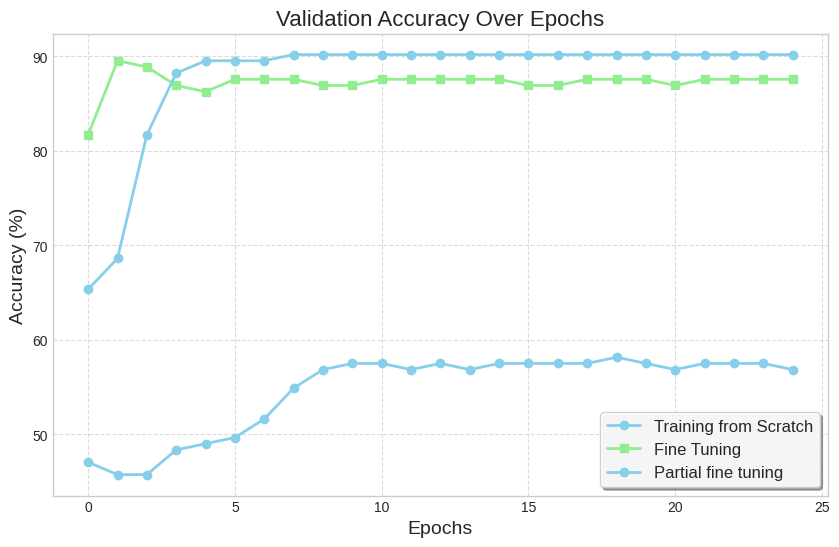

In [26]:
# Set the style
plt.style.use('seaborn-whitegrid')
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the data with improved style
epochs = np.arange(max_epochs)

# YOUR CODE HERE
# raise NotImplementedError()
ax.plot(epochs, 100 * np.array(accs_scratch['val']), color='skyblue',
       label='Training from Scratch', marker='o', linestyle='-', linewidth=2)
ax.plot(epochs, 100 * np.array(accs_ft['val']), color='lightgreen',
        label='Fine Tuning', marker='s', linestyle='-', linewidth=2)
ax.plot(epochs, 100 * np.array(accs_freezing['val']), color='skyblue',
       label='Partial fine tuning', marker='o', linestyle='-', linewidth=2)

# Set title and axis labels
ax.set_title('Validation Accuracy Over Epochs', fontsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)

# Set grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)
# Add legend with a border and shadow
ax.legend(frameon=True, fancybox=True, shadow=True, framealpha=0.9, fontsize=12)
plt.show()


In the end, for this small dataset, retraining the last layer performs just as well as global training. To conclude, let's make some predictions with the model on the validation dataset:

In [27]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(25,num_images//5*5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//5, 5, images_so_far)
                ax.axis('off')
                imshow(inputs.cpu().data[j],ax,'Predicted: {}'.format(class_names[preds[j]]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

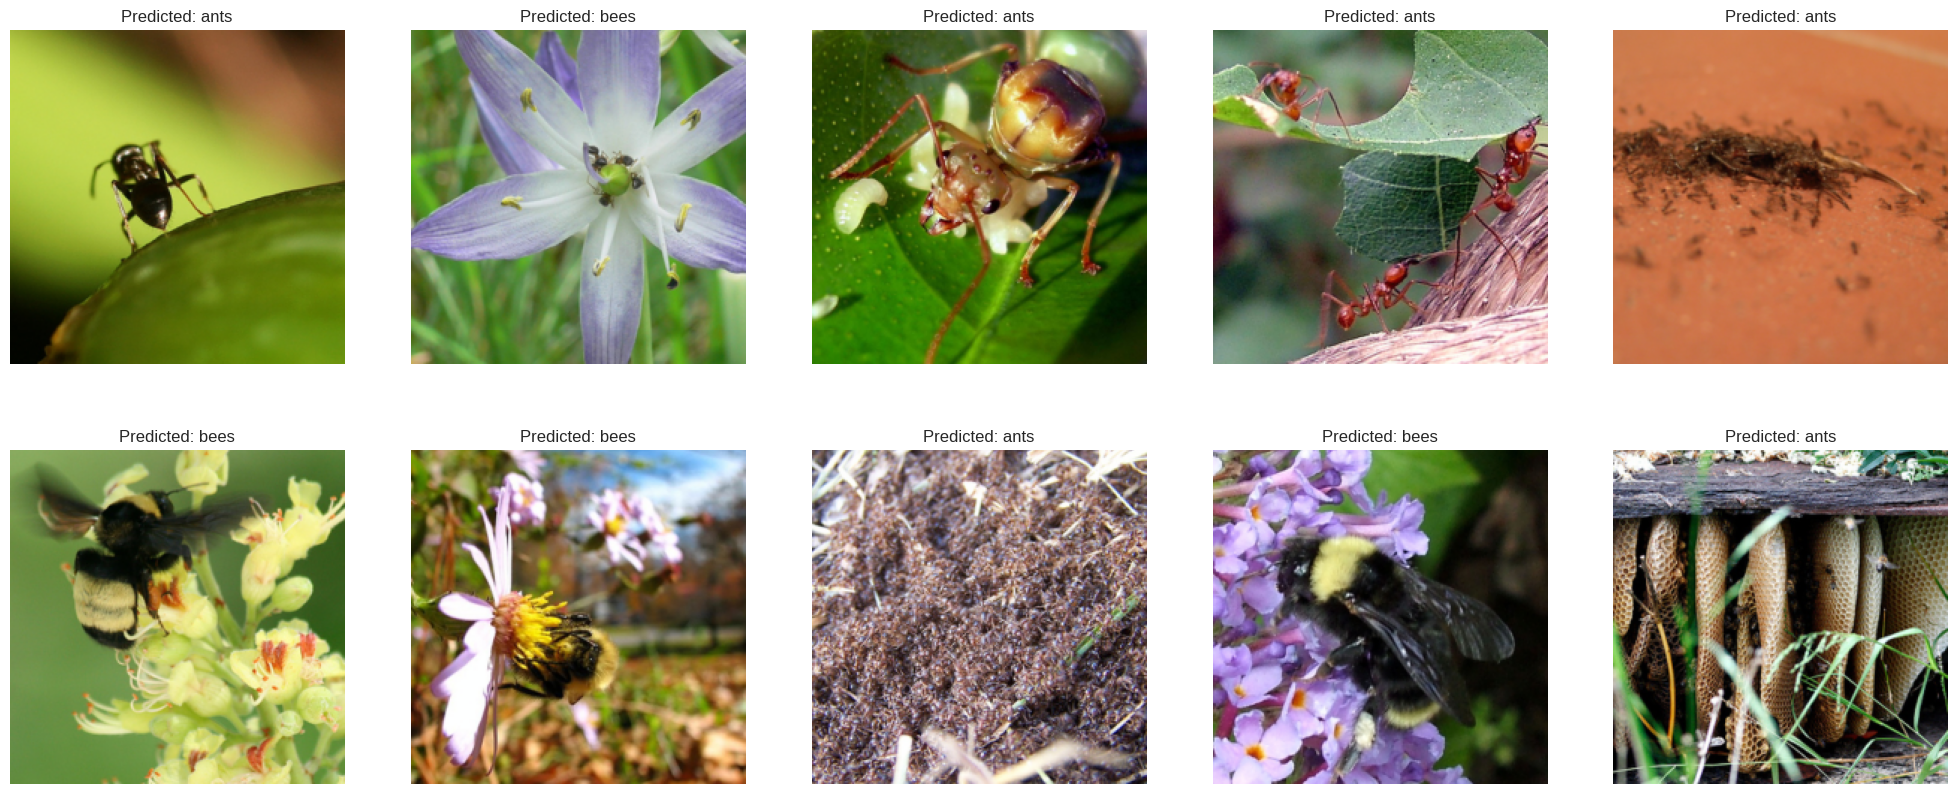

In [28]:
visualize_model(freezed_resnet)